<a href="https://colab.research.google.com/github/JankaUhrinova/Assessing-Unsupervised-Pretraining-for-improving-prediction-in-Digital-Pathology/blob/main/Autoencoder_and_Classifier_compariosn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import tensorflow as tf
import torchvision
import torch.nn.functional as F

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([28,28]),
    #transforms.Normalize((0.5), (0.5)),
    ])

In [ ]:
dataset = torchvision.datasets.ImageFolder("/content/drive/MyDrive/bakalarka/NCT-CRC-HE-100K/NCT-CRC-HE-100K/", transform)

In [ ]:

from torch.utils.data import random_split

In [ ]:
pretraining_data, training_data_20, training_data_15, training_data_7, training_data_5, training_data_2, training_data_1, testing_data = random_split(dataset, [30000, 20000, 15000, 7000, 5000, 2000, 1000, 20000])                                                                                                                                                                                                                                                                                                                                         

Encoder is a model that will serve as the encoder for the AutoEncoder as well as a classifier.

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(3, 32, kernel_size = 3, stride = 2, padding = 1)
        #self.conv0_bn = nn.BatchNorm2d(32)
        self.conv0_drop = nn.Dropout2d(0.25)
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        #self.conv1_bn = nn.BatchNorm2d(64)
        self.conv1_drop = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        #self.conv2_bn = nn.BatchNorm2d(128)
        self.conv2_drop = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
        #self.conv3_bn = nn.BatchNorm2d(256)
        self.conv3_drop = nn.Dropout2d(0.25)
        self.fc = nn.Linear(12544, 9)
    
    def forward(self, x):
        x = x.view(-1, 3, 28, 28)
        x = F.leaky_relu(self.conv0(x), 0.2)
        #x = self.conv0_bn(x)
        x = self.conv0_drop(x)
        x = F.leaky_relu(self.conv1(x), 0.2)
        #x = self.conv1_bn(x)
        x = self.conv1_drop(x)
        x = F.leaky_relu(self.conv2(x), 0.2)
        #x = self.conv2_bn(x)
        x = self.conv2_drop(x)
        x = F.leaky_relu(self.conv3(x), 0.2)
        #x = self.conv3_bn(x)
        x = self.conv3_drop(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(9, 256*7*7)
        self.trans_conv1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        #self.trans_conv1_bn = nn.BatchNorm2d(128)
        self.trans_conv2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        #self.trans_conv2_bn = nn.BatchNorm2d(64)
        self.trans_conv3 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        #self.trans_conv3_bn = nn.BatchNorm2d(32)
        self.trans_conv4 = nn.ConvTranspose2d(32, 3, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
    
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 7, 7)
        x = F.relu(self.trans_conv1(x))
        #x = self.trans_conv1_bn(x)
        x = F.relu(self.trans_conv2(x))
        #x = self.trans_conv2_bn(x)
        x = F.relu(self.trans_conv3(x))
        #x = self.trans_conv3_bn(x)
        x = self.trans_conv4(x)
        x = torch.tanh(x)
        
        return x 

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, Encoder, Decoder):
        super().__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def forward(self, x):
        x1 = self.Encoder(x)
        x2 = self.Decoder(x1)
        return x2

In [ ]:
E = Encoder().to(device).float()
D = Decoder().to(device).float()
AE = AutoEncoder(E,D).to(device).float()

In [ ]:

loss_function_pretraining = nn.MSELoss()
loss_function_training = nn.CrossEntropyLoss()

Training code that used for training the AutoEncoder -> pretraining the classifier.

In [ ]:
def train_AutoEncoder(model, optimizer, dataloader, epochs = 10):
  epochs = epochs
  losses = []
  for epoch in range(epochs):
      print(epoch)
      for data in dataloader:
        data_img = data[0]*2 - 1          #Converting the real images to have values between -1 and 1
        data_img = data_img.to(device)     #Passing to GPU
        
        # Output of Autoencoder
        reconstructed = model(data_img)
        
        # Calculating the loss function
        loss = loss_function_pretraining(reconstructed, data_img)
        
        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Storing the losses in a list for plotting
        losses.append(loss.detach().cpu().numpy())
  
  # Defining the Plot Style
  plt.style.use('fivethirtyeight')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  
  # Plotting the last 100 values
  plt.plot(losses[-100:])


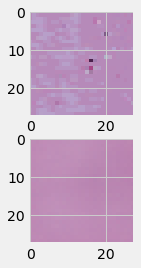

In [ ]:
fig, axs = plt.subplots(2)
 
# Reshape the array for plotting
image = pretraining_data[10][0]
axs[0].imshow(image.permute(1, 2, 0))
image = image*2-1
image = image.to(device)
#print(image)
recon = AE(image)
#print(recon)
recon = (recon+1)/2
recon = recon.cpu().detach().reshape([3,28,28])
# print(recon)
# print(tf.shape(recon))
axs[1].imshow(recon.permute(1, 2, 0))

In [ ]:
pretraining_dataloader = DataLoader(pretraining_data, batch_size = 64, num_workers = 2)

In [ ]:
optimizer = optim.Adam(AE.parameters(), lr = 0.0002, betas = (0.5, 0.999))

0
1
2
3
4
5
6
7
8
9


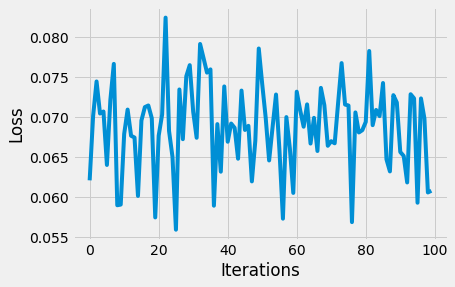

In [ ]:
train_AutoEncoder(AE, optimizer, pretraining_dataloader, 10)

In [ ]:
PATH = "/content/drive/MyDrive/bakalarka/trainedClassifier.pt"

# Save
torch.save(E.state_dict(), PATH)

In [ ]:
print(E.state_dict())

OrderedDict([('conv0.weight', tensor([[[[ 0.1464,  0.0623,  0.0065],
          [ 0.0747,  0.1151, -0.1672],
          [-0.1400,  0.1788, -0.0633]],

         [[ 0.1184, -0.0540,  0.1091],
          [ 0.0609,  0.1958,  0.1091],
          [-0.0311,  0.0482, -0.1370]],

         [[-0.0386,  0.0752,  0.0592],
          [ 0.0484, -0.1542, -0.0752],
          [-0.1767,  0.1017, -0.0872]]],


        [[[-0.1518, -0.0683,  0.1478],
          [-0.0346, -0.0899,  0.1073],
          [-0.0966, -0.1195, -0.1713]],

         [[-0.1566,  0.1715, -0.0204],
          [-0.0366,  0.1573,  0.2096],
          [ 0.2270,  0.1943, -0.0691]],

         [[ 0.0730, -0.0746, -0.0086],
          [ 0.0967, -0.1448,  0.1374],
          [ 0.1046, -0.0445, -0.0457]]],


        [[[ 0.1319,  0.1000, -0.1420],
          [-0.1724, -0.0420, -0.0283],
          [-0.1119, -0.0245,  0.1690]],

         [[ 0.1007,  0.1741,  0.0942],
          [-0.0024,  0.0465, -0.1463],
          [-0.0570, -0.0029, -0.0548]],

         [[-0.

Training code that used for training the Classifier.

In [ ]:
def training_Classifier(model, optimizer, dataloader, epochs = 10):
    for epoch in range(1, epochs + 1):
        loss_train = 0.0
        i  = 0
        for imgs, labels in dataloader:
            if (epoch == 1 and i%10 == 0):
              print(i)
            i += 1
            outputs = model(imgs.to(device))
            loss = loss_function_training(outputs, labels.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()

        print('Epoch {}, Training loss {}'.format(
            epoch, float(loss_train)/loss))



Testing the Classifier.

In [ ]:
def testing_Classifier(model, optimizer, dataloader, epochs = 10):
    model.eval()
    test_loss = 0
    correct = 0
    i = 0
    with torch.no_grad():
        for data, target in dataloader:
            if(i%100 == 0):
                print(i)
            i += 1
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_function_training(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dataloader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(dataloader.dataset),
        100. * correct / len(dataloader.dataset)))

Preparing dataloaders:

In [ ]:
training20_dataloader = DataLoader(training_data_20, batch_size = 64, num_workers = 2)
training15_dataloader = DataLoader(training_data_15, batch_size = 64, num_workers = 2)
training7_dataloader = DataLoader(training_data_7, batch_size = 64, num_workers = 2)
training5_dataloader = DataLoader(training_data_5, batch_size = 64, num_workers = 2)
training2_dataloader = DataLoader(training_data_2, batch_size = 64, num_workers = 2)
training1_dataloader = DataLoader(training_data_1, batch_size = 64, num_workers = 2)
testing_dataloader = torch.utils.data.DataLoader(testing_data, num_workers = 2)

Creating a new model that will be trained and tested with training sets of different sizes.

In [ ]:
Classifier20 = Encoder().to(device).float()
Classifier20.load_state_dict(torch.load(PATH))
Classifier20.eval()
print(Classifier20.state_dict())

OrderedDict([('conv0.weight', tensor([[[[ 0.1464,  0.0623,  0.0065],
          [ 0.0747,  0.1151, -0.1672],
          [-0.1400,  0.1788, -0.0633]],

         [[ 0.1184, -0.0540,  0.1091],
          [ 0.0609,  0.1958,  0.1091],
          [-0.0311,  0.0482, -0.1370]],

         [[-0.0386,  0.0752,  0.0592],
          [ 0.0484, -0.1542, -0.0752],
          [-0.1767,  0.1017, -0.0872]]],


        [[[-0.1518, -0.0683,  0.1478],
          [-0.0346, -0.0899,  0.1073],
          [-0.0966, -0.1195, -0.1713]],

         [[-0.1566,  0.1715, -0.0204],
          [-0.0366,  0.1573,  0.2096],
          [ 0.2270,  0.1943, -0.0691]],

         [[ 0.0730, -0.0746, -0.0086],
          [ 0.0967, -0.1448,  0.1374],
          [ 0.1046, -0.0445, -0.0457]]],


        [[[ 0.1319,  0.1000, -0.1420],
          [-0.1724, -0.0420, -0.0283],
          [-0.1119, -0.0245,  0.1690]],

         [[ 0.1007,  0.1741,  0.0942],
          [-0.0024,  0.0465, -0.1463],
          [-0.0570, -0.0029, -0.0548]],

         [[-0.

In [ ]:
optimizer = optim.Adam(Classifier20.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [ ]:
training_Classifier(Classifier20, optimizer, training20_dataloader, 10)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
Epoch 1, Training loss 363.0337219238281
Epoch 2, Training loss 308.98834228515625
Epoch 3, Training loss 297.3359069824219
Epoch 4, Training loss 296.40093994140625
Epoch 5, Training loss 297.8230285644531
Epoch 6, Training loss 301.6169128417969
Epoch 7, Training loss 304.58050537109375
Epoch 8, Training loss 305.2511291503906
Epoch 9, Training loss 303.5496826171875
Epoch 10, Training loss 301.5729675292969


In [ ]:
testing_Classifier(Classifier20, optimizer, testing_dataloader)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18